##Library Imports

In [17]:
import copy
import math

import random
import numpy as np
import pandas as pd
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

!pip install flwr scikit-learn pandas numpy matplotlib
import flwr as fl

import warnings
warnings.filterwarnings("ignore")

##Dataset pre-processing


###Feature Selection (No need to run this if you already have the post-featureSelectionDataset)

In [ ]:
df = pd.read_csv("/content/diabetes_binary_health_indicators_BRFSS2015.csv")
print("Dataset shape:", df.shape)
df.head()


X = df.drop("Diabetes_binary", axis=1)
y = df["Diabetes_binary"]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


TOP_K = 10
# ================================
#FEATURE SELECTION
#PART 1: XGBoost Classifier
# ================================
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)

xgb.fit(X_scaled, y)

importances = xgb.feature_importances_

feature_imp = pd.Series(importances, index=X.columns)
feature_imp = feature_imp.sort_values(ascending=False)

print("\n=== Top Features by XGBoost Importance ===")
print(feature_imp.head(TOP_K))

top_features_xgb = feature_imp.head(TOP_K).index.tolist()

print("\nTop 10 XGB Features:")
print(top_features_xgb)


#PART 2: Mutual Information
mi_scores = mutual_info_classif(X_scaled, y, random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

top_features_mi = mi_scores.head(TOP_K).index.tolist()

print("\nTop 10 MI Features:")
print(mi_scores.head(TOP_K))

# Combine XGB + MI importance
final_features = list(
    set(top_features_mi + top_features_xgb)
)

print("\nFinal Selected Features:", final_features)
X_selected = df[final_features]


df_final = X_selected.copy()
df_final["Diabetes_binary"] = y.values  # or y.reset_index(drop=True)

print("Final dataset shape (with target):", df_final.shape)
print(df_final.head())

# 2. Export to CSV
output_path = "/content/cdc_diabetes_preprocessed_dataset.csv"
df_final.to_csv(output_path, index=False)

print(f"\nSaved final dataset with features + target to:\n{output_path}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/diabetes_binary_health_indicators_BRFSS2015.csv'

##Load Processed Dataset

In [18]:
RANDOM_SEED = 42  # or keep whatever you used before
csv_path = "cdc_diabetes_preprocessed_dataset.csv"
def load_cdc_diabetes(csv_path: str):

    # Read CSV (assume it already has a header row)
    df = pd.read_csv(csv_path)
    print(df["Diabetes_binary"].value_counts())

    _, df = train_test_split(
    df,
    test_size=0.2,                    # keep 50% of dataset
    stratify=df["Diabetes_binary"],   # keep class balance
    random_state=42
    )

    print(df["Diabetes_binary"].value_counts())

    #print(df_half["Diabetes_binary"].value_counts())

    # Make sure the target column exists
    if "Diabetes_binary" not in df.columns:
        raise ValueError("Expected a 'Diabetes_binary' column in the CSV.")

    # Replace missing values with column mode (like in your adult loader)
    df.fillna(df.mode().iloc[0], inplace=True)

    # Binary label: already 0/1, but make sure it's int
    df["Diabetes_binary"] = df["Diabetes_binary"].astype(int)

    # Split into features and target
    X = df.drop("Diabetes_binary", axis=1)
    y = df["Diabetes_binary"].values

    # --- Feature typing ---
    # For the CDC Diabetes dataset, most columns are numeric (0/1 or integer).
    # We’ll treat all columns as numeric by default:
    numeric_features = X.columns.tolist()
    categorical_features = []  # add here if your CSV has categoricals

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            # Only include this if you actually have categorical columns:
            # ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ],
        remainder="drop"
    )

    X_processed = preprocessor.fit_transform(X).astype(np.float32)

    X_train, X_test, y_train, y_test = train_test_split(
        X_processed,
        y,
        test_size=0.2,
        random_state=RANDOM_SEED,
        stratify=y
    )

    # Convert to PyTorch tensors (handle sparse just in case)
    X_train_t = torch.tensor(
        X_train.toarray() if hasattr(X_train, "toarray") else X_train
    )
    X_test_t = torch.tensor(
        X_test.toarray() if hasattr(X_test, "toarray") else X_test
    )
    y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    input_dim = X_train_t.shape[1]
    print("Train shape:", X_train_t.shape, "Test shape:", X_test_t.shape)
    print("Input dim:", input_dim)

    return (X_train_t, y_train_t), (X_test_t, y_test_t), input_dim

In [19]:
(X_train, y_train), (X_test, y_test), INPUT_DIM = load_cdc_diabetes(csv_path)

Diabetes_binary
0.0    218334
1.0     35346
Name: count, dtype: int64
Diabetes_binary
0.0    43667
1.0     7069
Name: count, dtype: int64
Train shape: torch.Size([40588, 14]) Test shape: torch.Size([10148, 14])
Input dim: 14


##Hyperparameters

In [20]:
#Hyperparameter for FL-Settings
RANDOM_SEED = 42
NUM_CLIENTS = 5
ROUNDS = 20  #no. of federated rounds
LOCAL_EPOCHS = 5
BATCH_SIZE = 64
LR = 5e-4

#Hyperparameters for DP-Settings (Gaussian-noise)  for single training test
CLIPPING_NORM = 1.0
NOISE_MULTIPLIER = 0.2

#Optimizing hyperparameters includes
# - increase number of local epochs
# - increase federated rounds
# - decrease learning rate
# - DO NOT INCREASE NO. OF CLIENTS (more clients == more aggregated noise == less performace accurancy)
# - reduce noise multiplier ( however less noise == less privacy )( optimum value is between 0.05 to 0.30)

In [21]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

###Create clients

In [22]:
def make_federated_loaders(X_train, y_train, num_clients=NUM_CLIENTS):
    dataset = TensorDataset(X_train, y_train)
    total = len(dataset)

    indices = np.random.permutation(total)
    split_sizes = [total // num_clients] * num_clients
    split_sizes[-1] += total - sum(split_sizes)

    client_indices = np.split(indices, np.cumsum(split_sizes)[:-1])

    loaders = []
    for idxs in client_indices:
        subset = Subset(dataset, idxs)
        loader = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True)
        loaders.append(loader)

    return loaders

client_loaders = make_federated_loaders(X_train, y_train)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=256, shuffle=False)
len(client_loaders), sum(len(l.dataset) for l in client_loaders)


(5, 40588)

###Gaussian Noise Function

In [23]:
def clip_and_add_gaussian_noise_fast(update, clipping_norm, noise_multiplier):
    # Compute global L2 norm without flattening
    l2_norm = torch.sqrt(sum((v * v).sum() for v in update.values()))

    # Clip if needed
    if l2_norm > clipping_norm:
        scale = clipping_norm / (l2_norm + 1e-9)
        for k in update:
            update[k].mul_(scale)

    # Add DP noise
    if noise_multiplier > 0:
        std = noise_multiplier * clipping_norm
        for k in update:
            noise = torch.normal(
                mean=0.0,
                std=std,
                size=update[k].shape,
                device=update[k].device
            )
            update[k].add_(noise)

    return update


###Local Traning function for Client

In [24]:
def local_train(model, loader, epochs=LOCAL_EPOCHS):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.BCEWithLogitsLoss()

    for _ in range(epochs):
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=True):
                logits = model(xb)
                loss = criterion(logits, yb)

            loss.backward()
            optimizer.step()



###Federated Server

In [25]:
def federated_train(
    noise_multiplier,
    clipping_norm,
    rounds=ROUNDS,
    local_epochs=LOCAL_EPOCHS,
    verbose=True
):

    global_model = DiabetesMLP(INPUT_DIM).to(DEVICE)
    global_params = {k: v.clone() for k, v in global_model.state_dict().items()}

    best_loss = float("inf")
    best_acc  = 0.0
    best_params = None

    history = []

    for rnd in range(1, rounds + 1):
        print(f"\n---- Round {rnd}/{ROUNDS} ----")
        client_updates = []

        for loader in client_loaders:
            client_model = DiabetesMLP(INPUT_DIM).to(DEVICE)
            client_model.load_state_dict(global_params)

            # FAST local training
            local_train(client_model, loader, epochs=local_epochs)

            # Compute delta in-place (faster)
            delta = {}
            for k, v in client_model.state_dict().items():
                delta[k] = v - global_params[k]

            # FAST DP
            delta = clip_and_add_gaussian_noise_fast(
                delta, clipping_norm, noise_multiplier
            )
            client_updates.append(delta)

        # FedAvg aggregation
        for k in global_params:
            avg = sum(update[k] for update in client_updates) / len(client_updates)
            global_params[k] += avg

        global_model.load_state_dict(global_params)

        test_loss, test_acc = evaluate(global_model, test_loader)
        history.append((rnd, test_loss, test_acc))

        if verbose:
            print(f"Round {rnd}/{rounds} | Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")

        if test_loss < best_loss:
            best_loss = test_loss
            best_acc = test_acc
            best_params = {k: v.clone() for k, v in global_model.state_dict().items()}

    if best_params is not None:
        global_model.load_state_dict(best_params)

    return global_model, history, best_loss, best_acc


###MLP NN Classifier

In [26]:
class DiabetesMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)


#To optimize it , I have increase capacity of the model from 64 to 128.

###Evaluation Function

In [27]:
def evaluate(model, loader):
    model.eval()
    criterion = nn.BCEWithLogitsLoss()

    correct, total, total_loss = 0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            preds = (torch.sigmoid(logits) >= 0.5).float()
            loss = criterion(logits, yb)

            total += yb.size(0)
            correct += (preds == yb).sum().item()
            total_loss += loss.item() * yb.size(0)

    return total_loss / total, correct / total


Experimental Test-cases(Noise Multipliers)

In [28]:
noise_levels = [0.0, 0.10, 0.15, 0.20, 0.30, 0.50]
clip_norm_values = [0.5, 1.0, 1.5, 2.0]

###Run Training

In [29]:
results = []
histories = {}

for clip_norm in clip_norm_values:
    print("\n============================================================")
    print(f"Running experiments for CLIPPING_NORM = {clip_norm}")
    print("============================================================")

    for sigma in noise_levels:

        print("-----------------------------------------")
        print(f"Training with noise_multiplier σ = {sigma}, clipping_norm = {clip_norm}")
        print("-----------------------------------------")

        model, history, best_loss, best_acc = federated_train(
            noise_multiplier=sigma,
            clipping_norm=clip_norm,
            rounds=ROUNDS,
            local_epochs=LOCAL_EPOCHS,
            verbose=True
        )
        histories[(sigma, clip_norm)] = history

        # Compute privacy epsilon if needed
        epsilon = (1.0 / sigma) if sigma > 0 else math.inf

        print(f"Done. Best Loss: {best_loss:.4f}, Best Acc: {best_acc:.4f}, Epsilon (approx): {epsilon}")
        results.append({
            "sigma": sigma,
            "clipping_norm": clip_norm,
            "epsilon_approx": epsilon,
            "best_loss": best_loss,
            "best_acc": best_acc
        })



Running experiments for CLIPPING_NORM = 0.5
-----------------------------------------
Training with noise_multiplier σ = 0.0, clipping_norm = 0.5
-----------------------------------------

---- Round 1/20 ----
Round 1/20 | Loss: 0.6413 | Acc: 0.8607

---- Round 2/20 ----
Round 2/20 | Loss: 0.5726 | Acc: 0.8613

---- Round 3/20 ----
Round 3/20 | Loss: 0.4902 | Acc: 0.8612

---- Round 4/20 ----
Round 4/20 | Loss: 0.4181 | Acc: 0.8622

---- Round 5/20 ----
Round 5/20 | Loss: 0.3689 | Acc: 0.8637

---- Round 6/20 ----
Round 6/20 | Loss: 0.3421 | Acc: 0.8634

---- Round 7/20 ----
Round 7/20 | Loss: 0.3292 | Acc: 0.8638

---- Round 8/20 ----
Round 8/20 | Loss: 0.3245 | Acc: 0.8640

---- Round 9/20 ----
Round 9/20 | Loss: 0.3223 | Acc: 0.8637

---- Round 10/20 ----
Round 10/20 | Loss: 0.3217 | Acc: 0.8635

---- Round 11/20 ----
Round 11/20 | Loss: 0.3213 | Acc: 0.8636

---- Round 12/20 ----
Round 12/20 | Loss: 0.3214 | Acc: 0.8638

---- Round 13/20 ----
Round 13/20 | Loss: 0.3214 | Acc: 0.86

###Results Table

In [14]:
results_df = pd.DataFrame(results)
results_df["epsilon_approx_str"] = results_df["epsilon_approx"].apply(
    lambda e: "∞" if math.isinf(e) else f"{e:.2f}"
)

results_df[["sigma", "clipping_norm", "epsilon_approx_str", "best_acc", "best_loss"]]


,sigma,clipping_norm,epsilon_approx_str,best_acc,best_loss
0,0.00,0.5,∞,0.863618,0.321330
1,0.10,0.5,10.00,0.863816,0.321502
2,0.15,0.5,6.67,0.863717,0.322783
3,0.20,0.5,5.00,0.861746,0.326297
4,0.30,0.5,3.33,0.854454,0.343778
5,0.50,0.5,2.00,0.860268,0.410532
6,0.75,0.5,1.33,0.691269,0.960512
7,1.00,0.5,1.00,0.678853,2.231277
8,0.00,1.0,∞,0.863914,0.321696
9,0.10,1.0,10.00,0.862140,0.322321


###Utility Privacy trade-off plot

###Accuracy vs. Noise plot

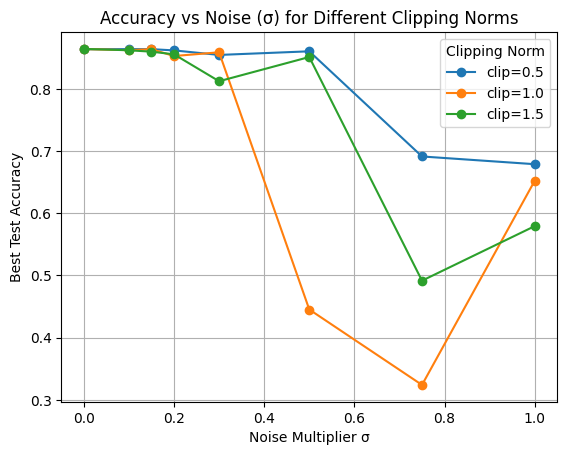

In [15]:
import matplotlib.pyplot as plt

plt.figure()

for clip in sorted(results_df["clipping_norm"].unique()):
    subset = results_df[results_df["clipping_norm"] == clip]
    subset = subset.sort_values("sigma")  # just to make lines smooth in order

    plt.plot(
        subset["sigma"],
        subset["best_acc"],
        marker='o',
        label=f"clip={clip}"
    )

plt.xlabel("Noise Multiplier σ")
plt.ylabel("Best Test Accuracy")
plt.title("Accuracy vs Noise (σ) for Different Clipping Norms")
plt.grid(True)
plt.legend(title="Clipping Norm")
plt.show()


###Loss vs. Noise plot

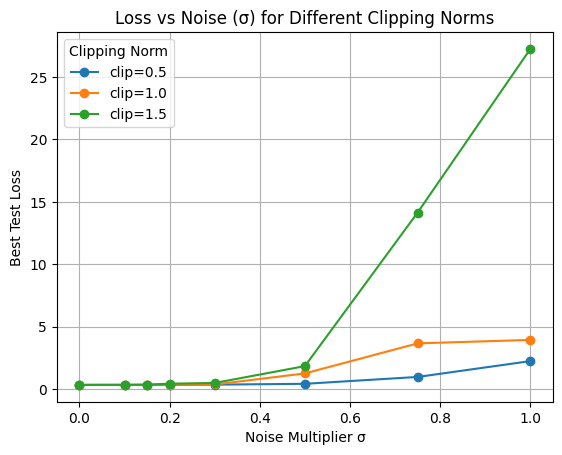

In [16]:
plt.figure()

for clip in sorted(results_df["clipping_norm"].unique()):
    subset = results_df[results_df["clipping_norm"] == clip]
    subset = subset.sort_values("sigma")

    plt.plot(
        subset["sigma"],
        subset["best_loss"],
        marker='o',
        label=f"clip={clip}"
    )

plt.xlabel("Noise Multiplier σ")
plt.ylabel("Best Test Loss")
plt.title("Loss vs Noise (σ) for Different Clipping Norms")
plt.grid(True)
plt.legend(title="Clipping Norm")
plt.show()


###Accuracy Vs. Epsilon plot

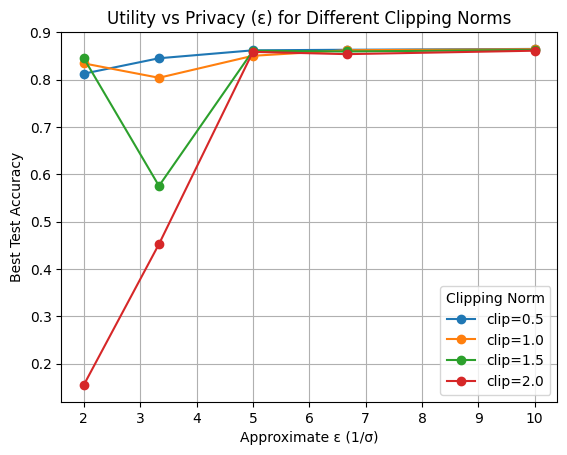

In [ ]:
finite_df = results_df.replace([math.inf], np.nan).dropna(subset=["epsilon_approx"])

plt.figure()

for clip in sorted(finite_df["clipping_norm"].unique()):
    subset = finite_df[finite_df["clipping_norm"] == clip]
    subset = subset.sort_values("epsilon_approx")

    plt.plot(
        subset["epsilon_approx"],
        subset["best_acc"],
        marker='o',
        label=f"clip={clip}"
    )

plt.xlabel("Approximate ε (1/σ)")
plt.ylabel("Best Test Accuracy")
plt.title("Utility vs Privacy (ε) for Different Clipping Norms")
plt.grid(True)
plt.legend(title="Clipping Norm")
plt.show()


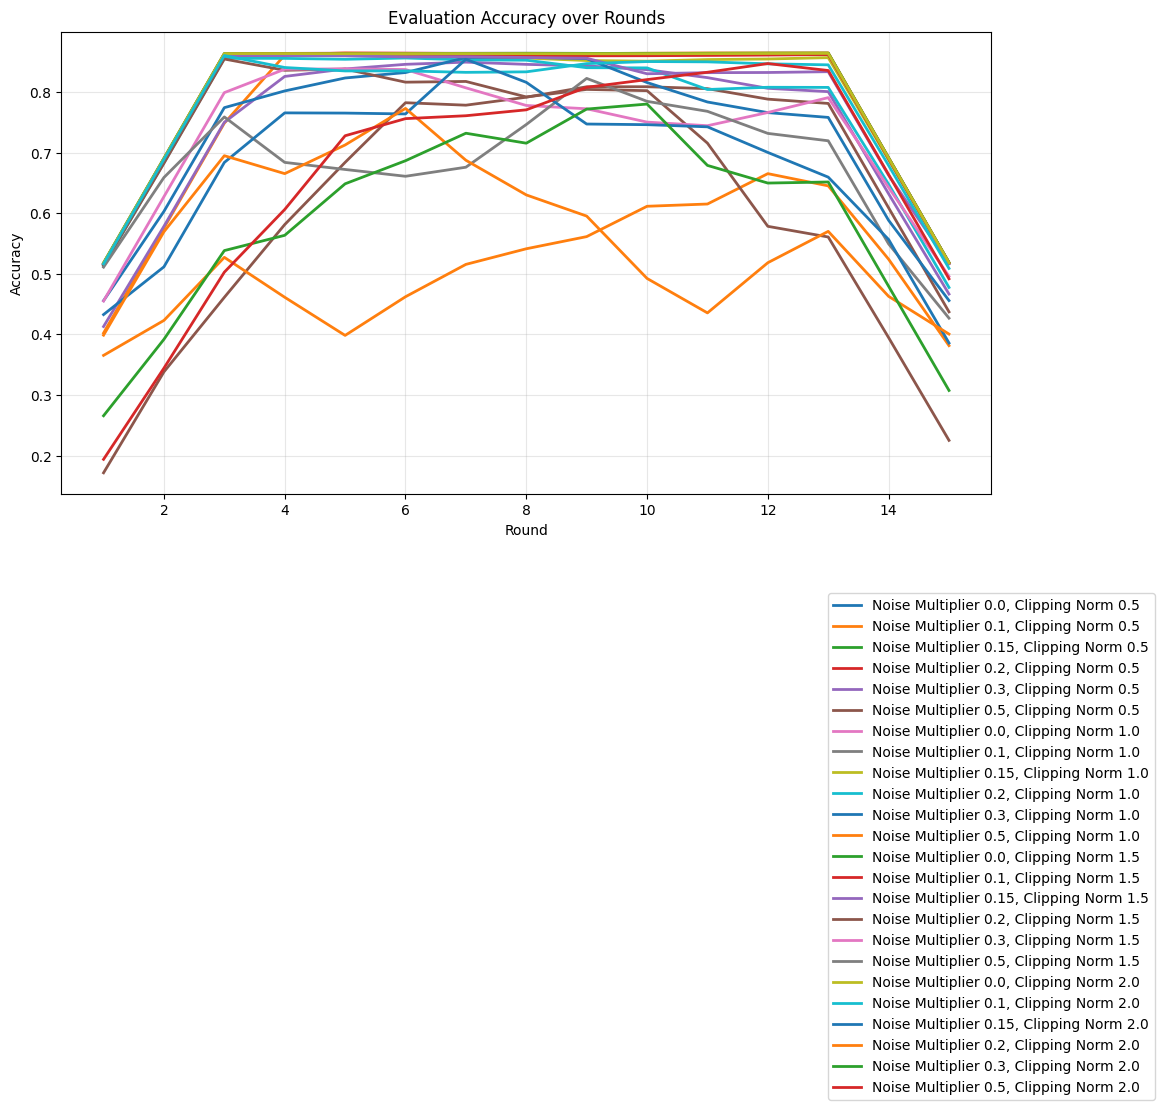

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))

for (sigma, clip), history in histories.items():
    # extract rounds & accuracy
    rounds = [h[0] for h in history]
    accs   = [h[2] for h in history]

    # Optional smoothing (looks better)
    # Use moving average smoothing with window=3
    smoothed = np.convolve(accs, np.ones(5)/5, mode='same')

    label = f"Noise Multiplier {sigma}, Clipping Norm {clip}"
    plt.plot(rounds, smoothed, linewidth=2,label=label )

plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy over Rounds")
plt.grid(True, alpha=0.3)
plt.legend(loc='upper center', bbox_to_anchor=(1, -0.2))
#plt.legend(loc="lower right", fontsize=9)
plt.tight_layout()
plt.show()
